In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [3]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train = pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/train.csv")
train_labels = pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv")
test_data = pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/test.csv")
sub = pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv")

# Data Understanding

In [3]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [4]:
train_labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [5]:
train = train.merge(train_labels, on='sequence')
train["state"].value_counts()

1    780840
0    777240
Name: state, dtype: int64

In [6]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


In [7]:
test_data.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [8]:
train.shape

(1558080, 17)

In [9]:
test_data.shape

(733080, 16)

In [10]:
train.sample(5)

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
244077,4067,454,57,-0.301391,-1.901261,-0.332820,-1.079646,0.095219,0.118175,-0.833333,-0.367939,-0.1,0.602601,1.743667,-1.905350,0.283461,1
1129624,18827,199,4,0.008501,0.069328,-0.999486,0.077876,-0.121696,-1.353777,0.265027,0.025954,0.3,0.093208,-0.235853,-0.016461,0.024297,1
932914,15548,170,34,-0.142968,0.299370,-0.332820,0.289381,0.304186,-0.240838,-0.027322,0.295420,-1.5,0.325867,0.727748,0.579218,23.185422,0
920178,15336,203,18,0.204019,0.117647,0.333847,-0.066372,-0.526929,-0.233358,0.242259,-0.196947,0.4,-0.054191,0.329944,0.074074,-36.236573,0
1402573,23376,337,13,-0.339258,-0.024160,0.333847,0.159292,1.212551,-1.166043,-0.363388,-0.069466,0.1,-0.227601,-0.482222,-0.004115,165.633845,1


In [11]:
train.describe()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,1.298350e+04,3.316331e+02,2.950000e+01,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02,5.011553e-01
std,7.496318e+03,1.958257e+02,1.731811e+01,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01,4.999988e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02,0.000000e+00
25%,6.491750e+03,1.617500e+02,1.475000e+01,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01,0.000000e+00
50%,1.298350e+04,3.350000e+02,2.950000e+01,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00,1.000000e+00
75%,1.947525e+04,5.010000e+02,4.425000e+01,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01,1.000000e+00
max,2.596700e+04,6.710000e+02,5.900000e+01,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02,1.000000e+00


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 1558080 entries, 0 to 1558079

Data columns (total 17 columns):

 #   Column     Non-Null Count    Dtype  

---  ------     --------------    -----  

 0   sequence   1558080 non-null  int64  

 1   subject    1558080 non-null  int64  

 2   step       1558080 non-null  int64  

 3   sensor_00  1558080 non-null  float64

 4   sensor_01  1558080 non-null  float64

 5   sensor_02  1558080 non-null  float64

 6   sensor_03  1558080 non-null  float64

 7   sensor_04  1558080 non-null  float64

 8   sensor_05  1558080 non-null  float64

 9   sensor_06  1558080 non-null  float64

 10  sensor_07  1558080 non-null  float64

 11  sensor_08  1558080 non-null  float64

 12  sensor_09  1558080 non-null  float64

 13  sensor_10  1558080 non-null  float64

 14  sensor_11  1558080 non-null  float64

 15  sensor_12  1558080 non-null  float64

 16  state      1558080 non-null  int64  

dtypes: float64(13), int64(4)

memory usage: 214.0 MB


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 733080 entries, 0 to 733079

Data columns (total 16 columns):

 #   Column     Non-Null Count   Dtype  

---  ------     --------------   -----  

 0   sequence   733080 non-null  int64  

 1   subject    733080 non-null  int64  

 2   step       733080 non-null  int64  

 3   sensor_00  733080 non-null  float64

 4   sensor_01  733080 non-null  float64

 5   sensor_02  733080 non-null  float64

 6   sensor_03  733080 non-null  float64

 7   sensor_04  733080 non-null  float64

 8   sensor_05  733080 non-null  float64

 9   sensor_06  733080 non-null  float64

 10  sensor_07  733080 non-null  float64

 11  sensor_08  733080 non-null  float64

 12  sensor_09  733080 non-null  float64

 13  sensor_10  733080 non-null  float64

 14  sensor_11  733080 non-null  float64

 15  sensor_12  733080 non-null  float64

dtypes: float64(13), int64(3)

memory usage: 89.5 MB


In [14]:
train.isnull().mean()*100

sequence     0.0
subject      0.0
step         0.0
sensor_00    0.0
sensor_01    0.0
sensor_02    0.0
sensor_03    0.0
sensor_04    0.0
sensor_05    0.0
sensor_06    0.0
sensor_07    0.0
sensor_08    0.0
sensor_09    0.0
sensor_10    0.0
sensor_11    0.0
sensor_12    0.0
state        0.0
dtype: float64

In [15]:
train.duplicated().sum()

0

In [16]:
test_data.duplicated().sum()

0

# Exploratory Data Analysis

Univariant Analysis

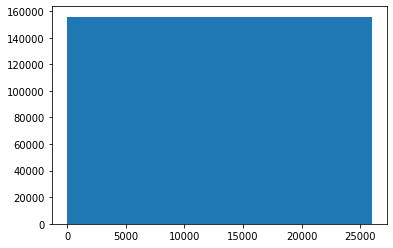

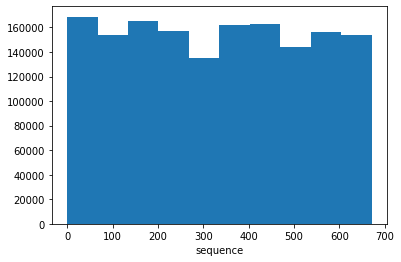

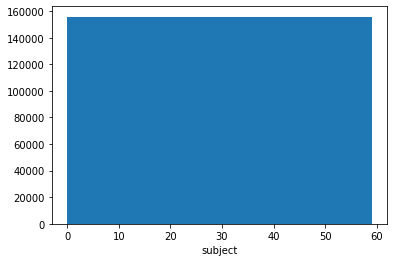

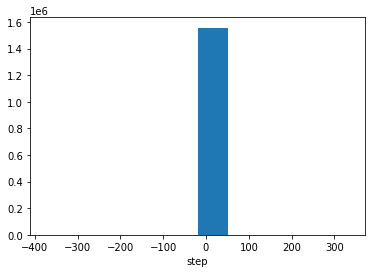

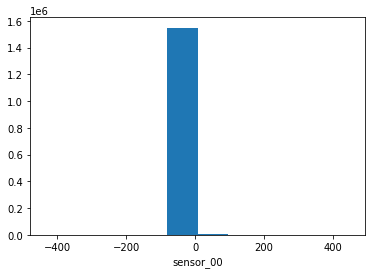

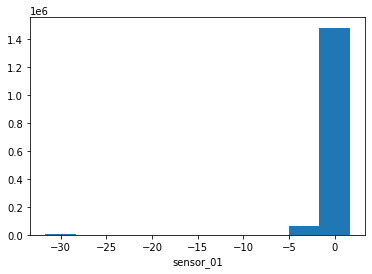

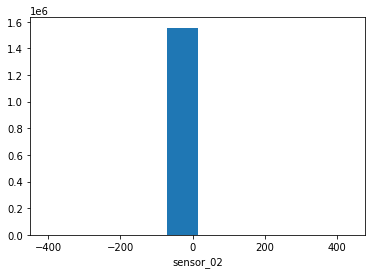

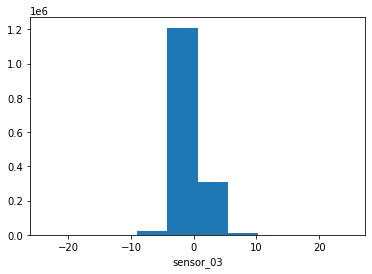

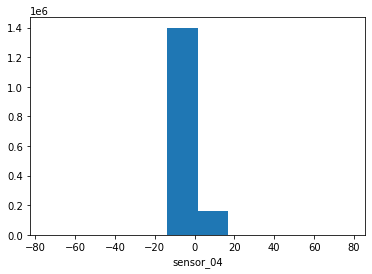

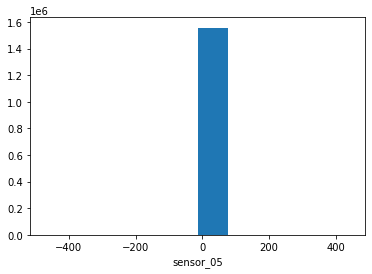

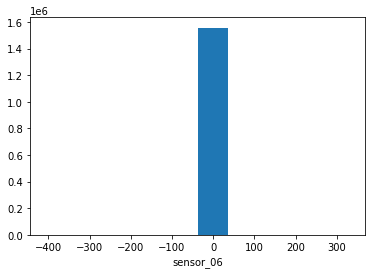

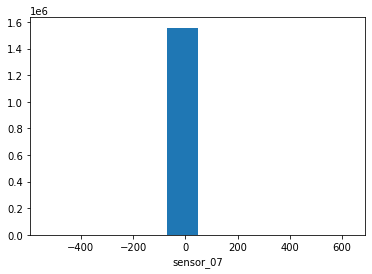

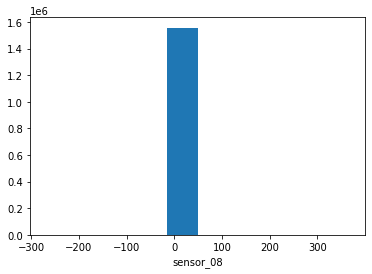

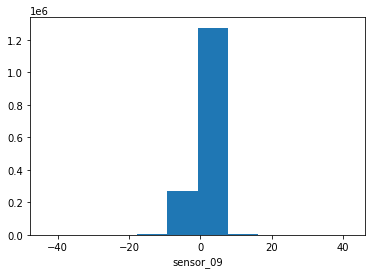

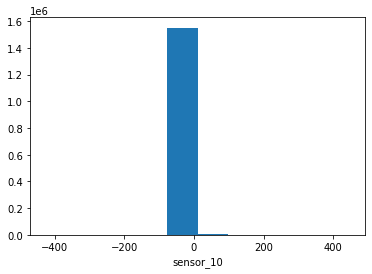

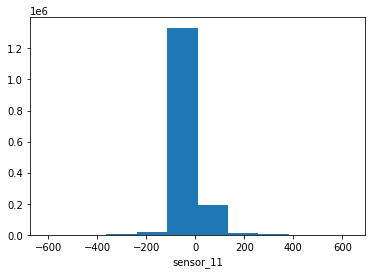

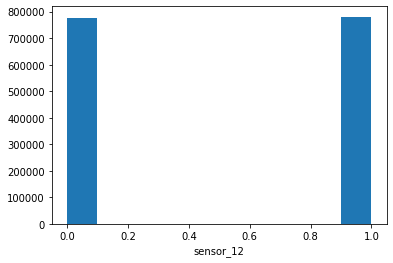

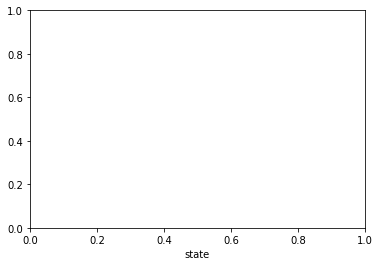

In [20]:
# Histogram
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(plt.hist(train[train.columns[i]]))
        plt.xlabel(train.columns[i])

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


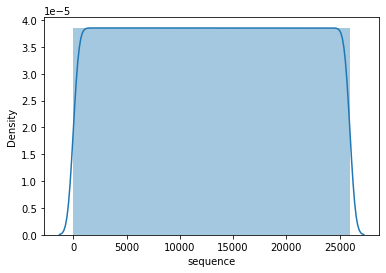

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


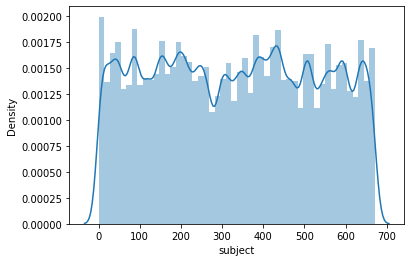

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


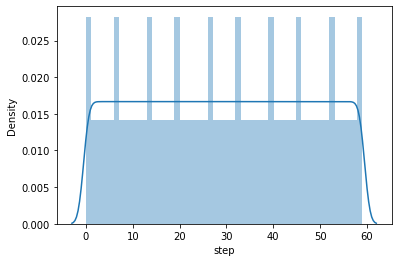

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


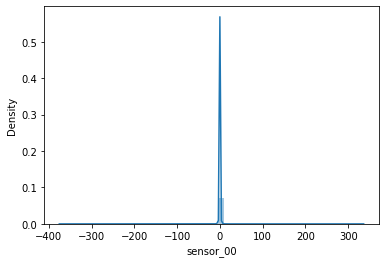

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


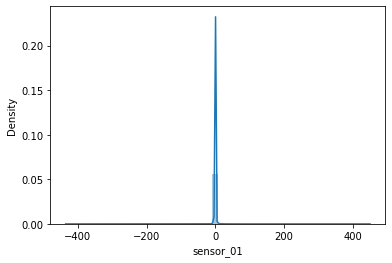

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


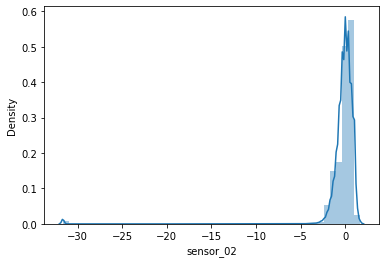

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


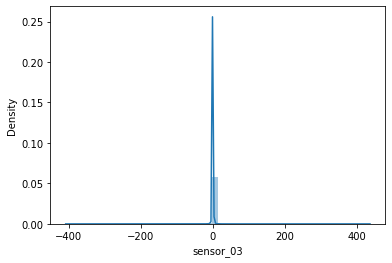

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


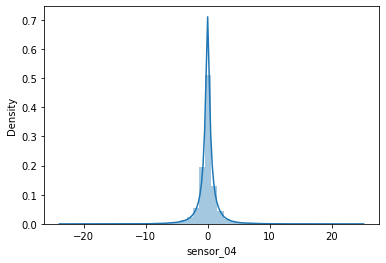

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


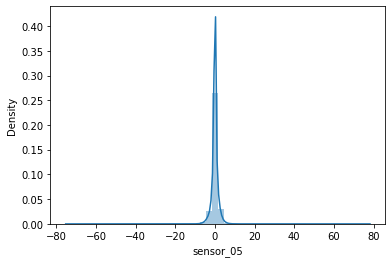

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


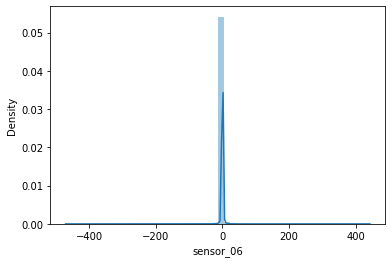

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


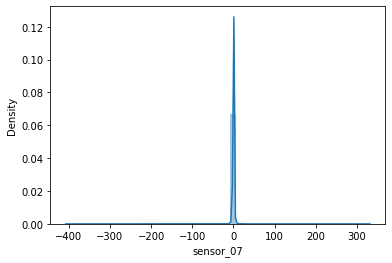

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


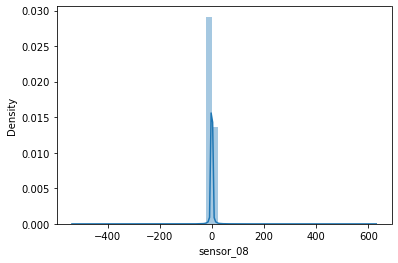

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


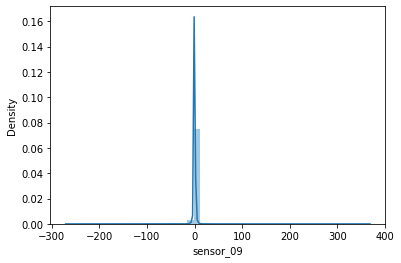

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


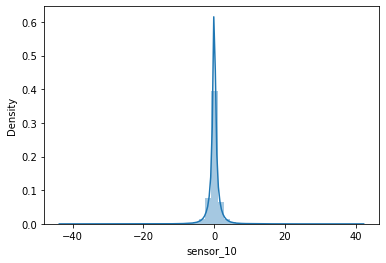

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


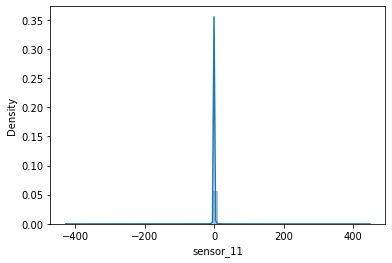

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


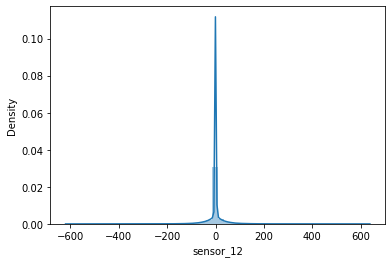

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


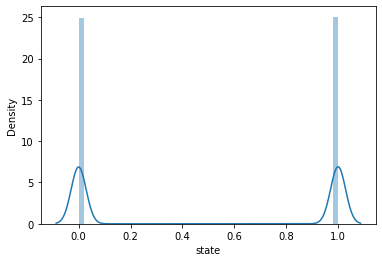

In [21]:
# Distplot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.distplot(train[train.columns[i]]))
        #plt.xlabel(train.columns[i])

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


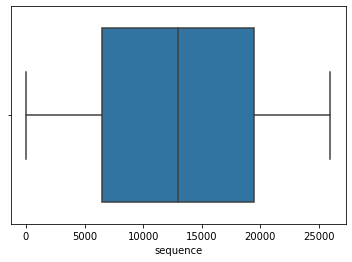

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


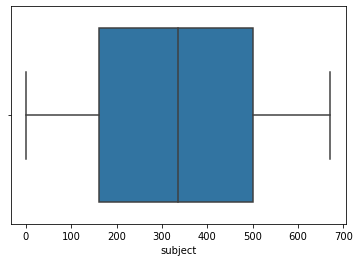

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


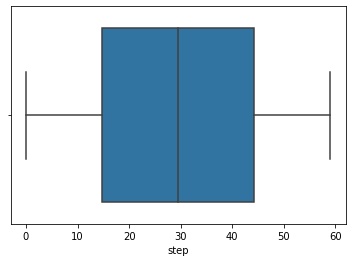

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


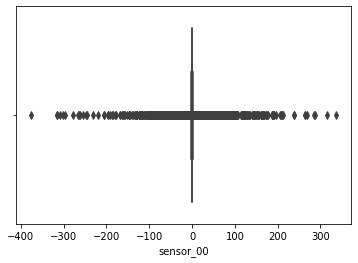

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


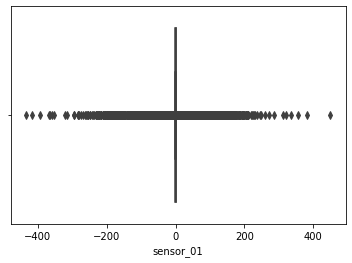

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


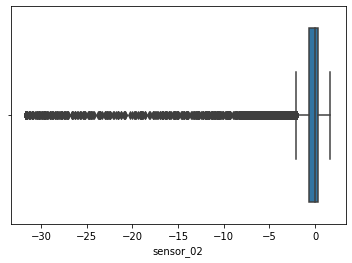

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


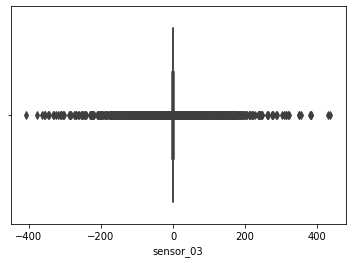

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


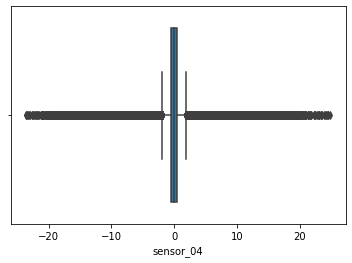

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


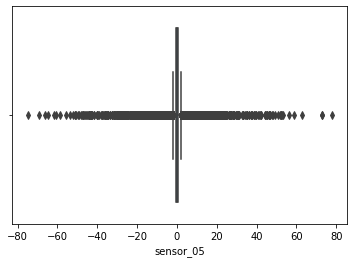

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


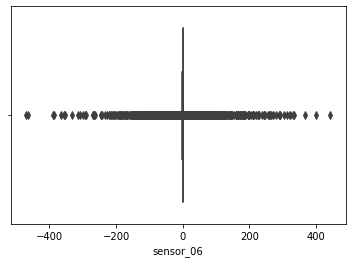

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


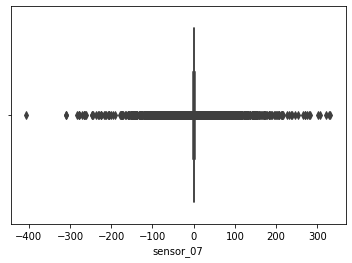

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


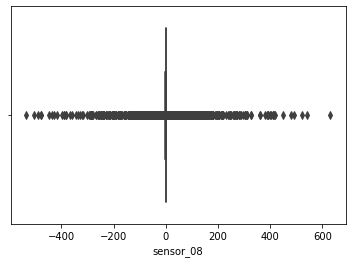

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


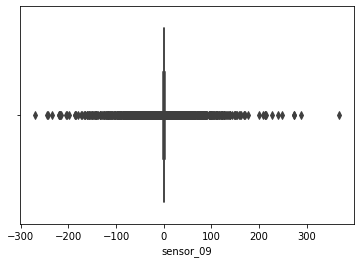

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


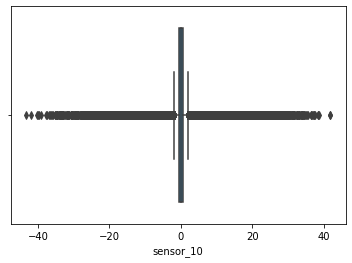

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


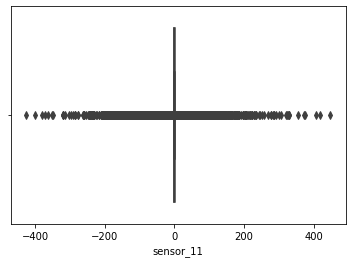

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


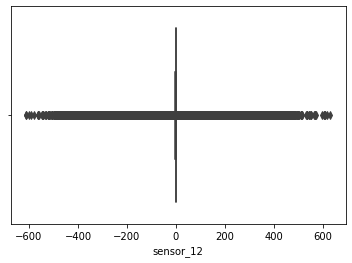

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


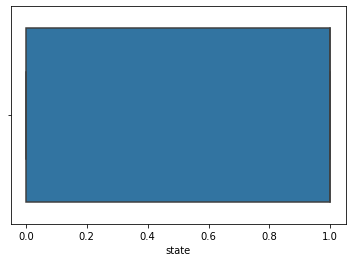

In [22]:
# Boxplot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.boxplot(train[train.columns[i]]))
        #plt.xlabel(train.columns[i])

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


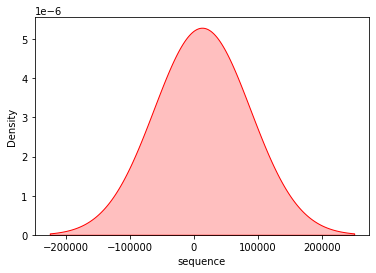

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


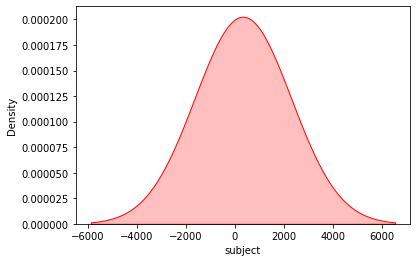

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


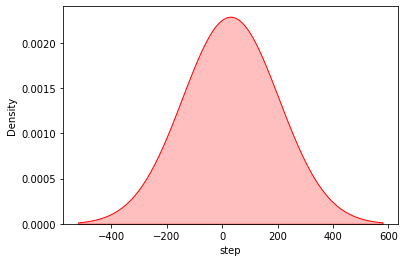

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


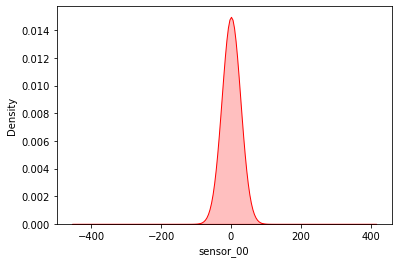

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


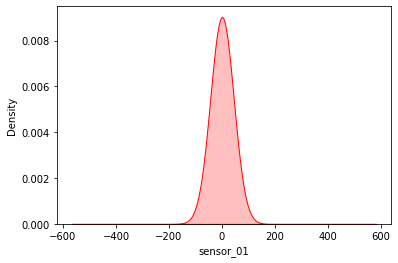

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


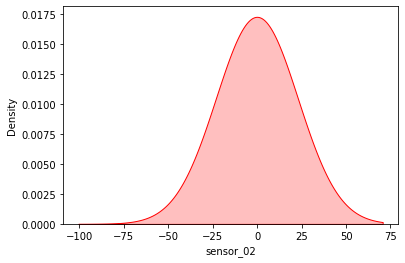

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


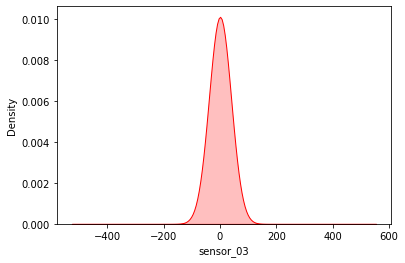

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


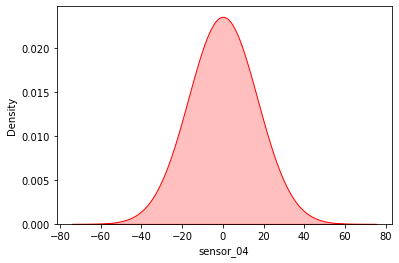

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


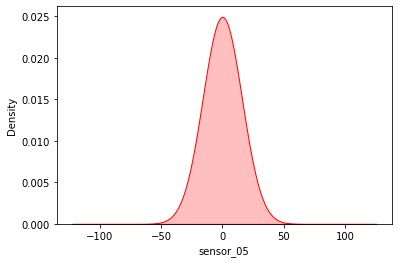

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


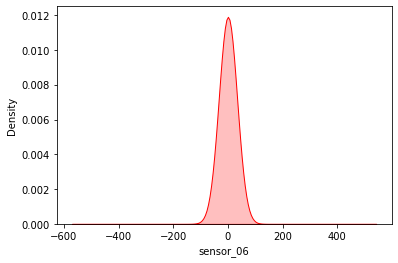

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


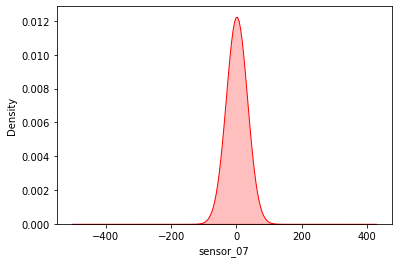

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


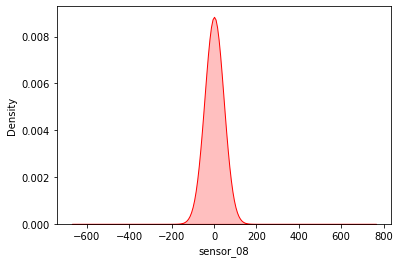

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


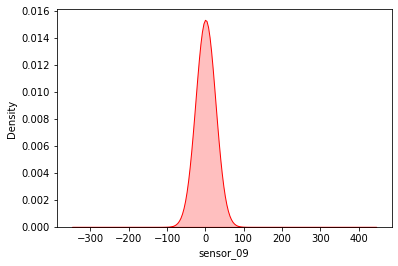

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


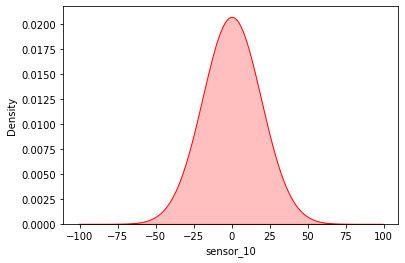

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


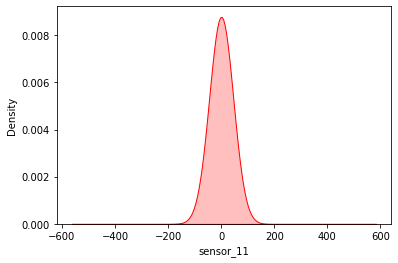

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


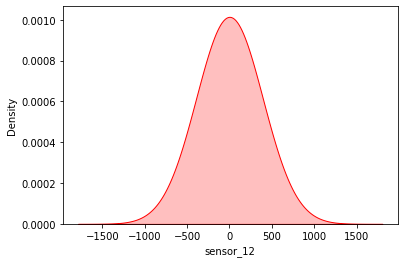

C:\Users\mohit\anaconda3\envs\ML_DL\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.

  warnings.warn(msg, FutureWarning)


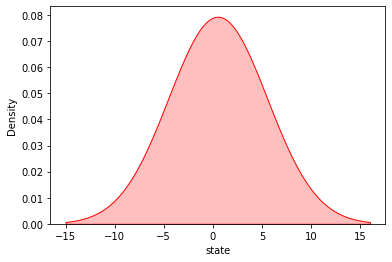

In [24]:
# Kde Plot
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        plt.show(sns.kdeplot(data=train, x=train[train.columns[i]], bw=10, shade=True, color="red"))
        #plt.xlabel(train.columns[i])

Multivariant Analysis

C:\Users\mohit\AppData\Local\Temp\ipykernel_7076\3375996227.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

  mask = np.triu(np.ones_like(train[sensors].corr(), dtype=np.bool))


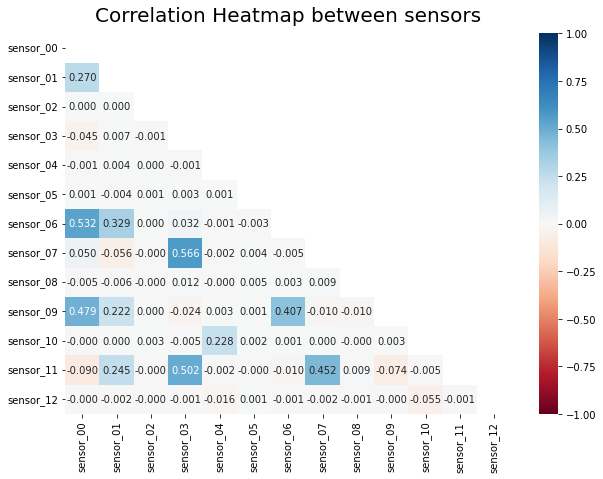

In [17]:
sensors = [col for col in train if col.startswith('sensor')]
fig, ax = plt.subplots(figsize=(10, 7))

mask = np.triu(np.ones_like(train[sensors].corr(), dtype=np.bool))
sns.heatmap(train[sensors].corr(), mask = mask,
            cmap = "RdBu", vmin = -1, vmax = 1, annot = True, fmt = '.3f')
ax.set_title('Correlation Heatmap between sensors', pad = 12, size=20)

plt.show()

In [18]:
train.shape

(1558080, 17)

In [20]:
test_data.shape

(733080, 16)

# Feature Transformation

Outlier Detection

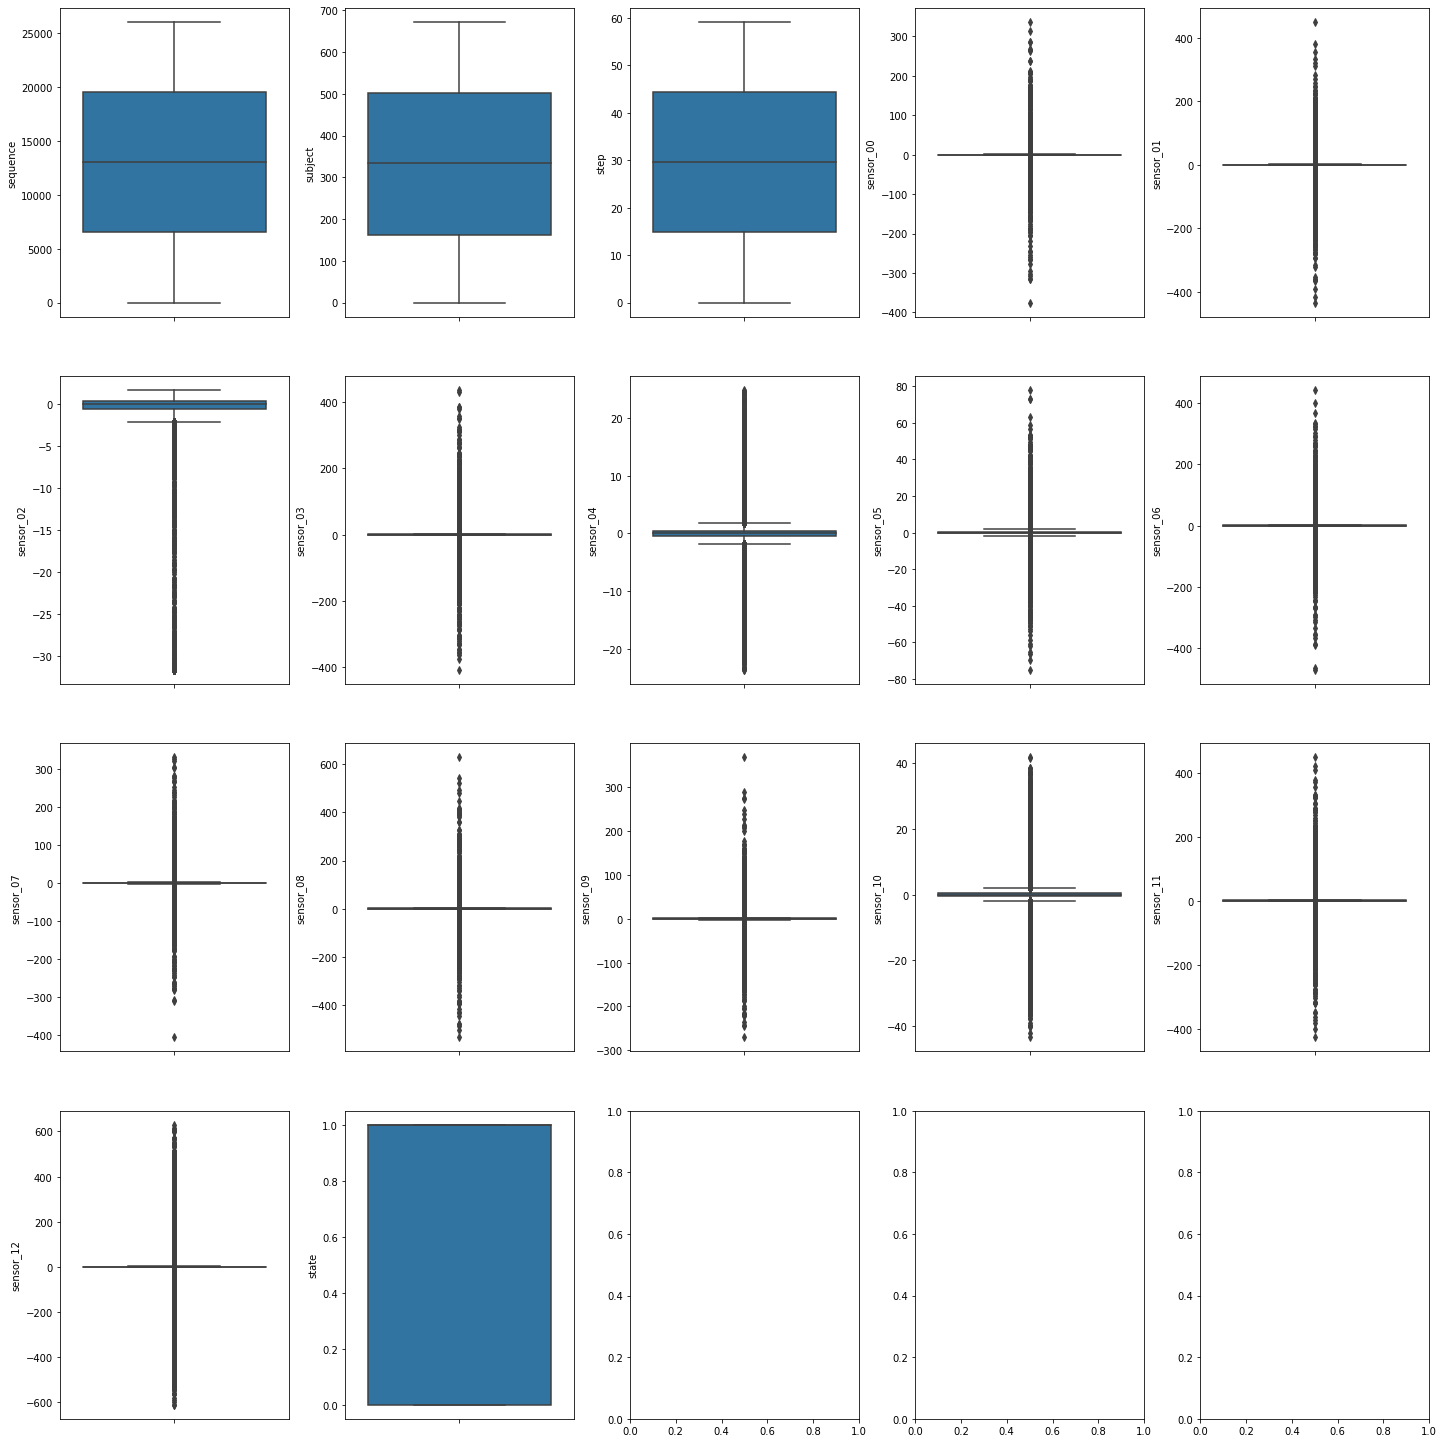

In [21]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 20))
index = 0
ax = ax.flatten()

for col in train.columns:
    sns.boxplot(y=col, data=train, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

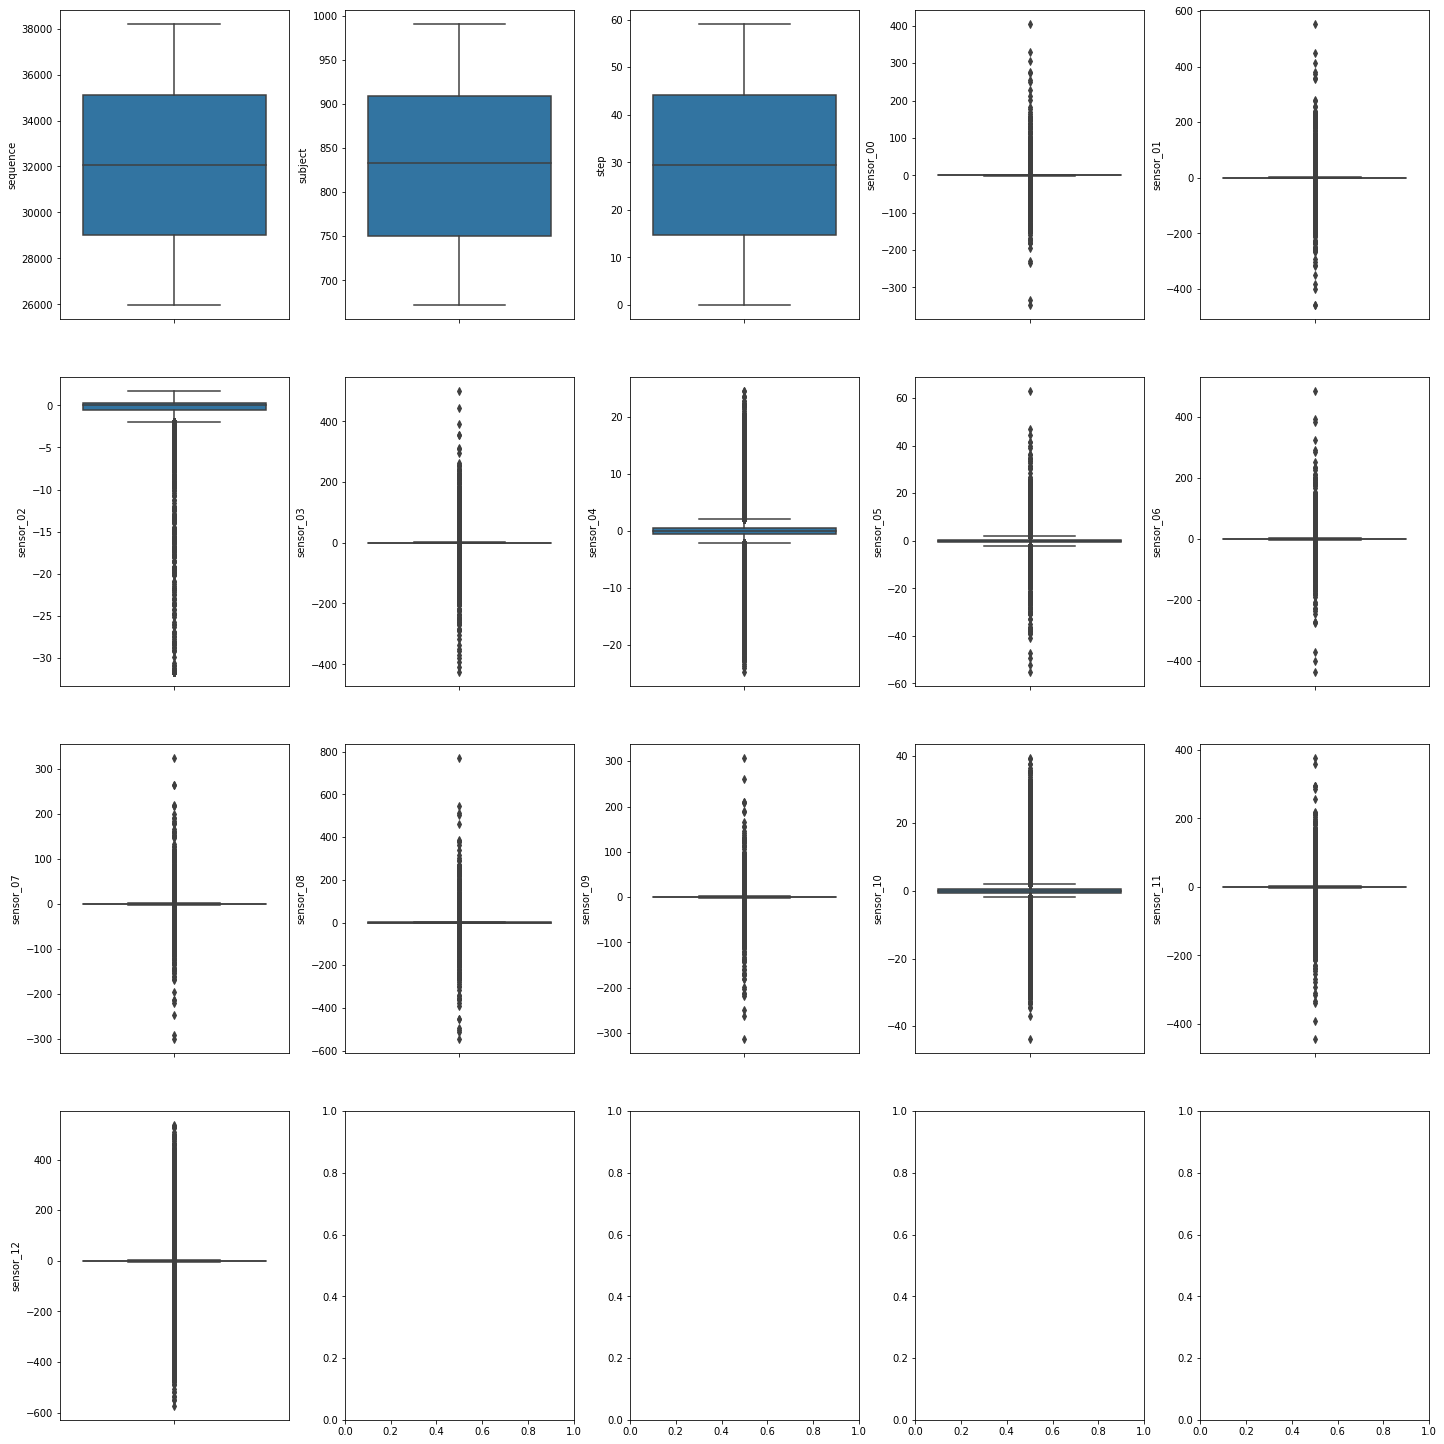

In [23]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 20))
index = 0
ax = ax.flatten()

for col in test_data.columns:
    sns.boxplot(y=col, data=test_data, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [24]:
for i in range(len(list(train.columns))):
    if train[train.columns[i]].dtypes == "int64" or train[train.columns[i]].dtypes == "float64":
        print(f'{train.columns[i]} : {train[train.columns[i]].skew()}')

sequence : 1.5388220530714856e-16

subject : 0.013993471792081238

step : 0.0

sensor_00 : -2.0920929040187852

sensor_01 : -6.0859880170773755

sensor_02 : -12.016829658863234

sensor_03 : -0.8478231958499634

sensor_04 : 0.21145579699345235

sensor_05 : -0.29497454112198573

sensor_06 : -1.3926838310426266

sensor_07 : -0.365475708986457

sensor_08 : 0.8541508078490551

sensor_09 : 0.577439485975323

sensor_10 : 0.23368513958291842

sensor_11 : -3.824734160752065

sensor_12 : 0.04047921599460055

state : -0.00462108887257954


In [27]:
for i in range(len(list(test_data.columns))):
    if test_data[test_data.columns[i]].dtypes == "int64" or test_data[test_data.columns[i]].dtypes == "float64":
        print(f'{test_data.columns[i]} : {test_data[test_data.columns[i]].skew()}')

sequence : -1.8654013163314126e-16

subject : 0.015558028043166965

step : 0.0

sensor_00 : 4.635284028155519

sensor_01 : -2.199320871340828

sensor_02 : -11.832722706051284

sensor_03 : -2.644361337003894

sensor_04 : 0.14047350713146842

sensor_05 : -0.41866560452819046

sensor_06 : 0.79972024723407

sensor_07 : 2.3819409490058603

sensor_08 : 1.8946970051741865

sensor_09 : -3.1522793442722863

sensor_10 : 0.12598076724326243

sensor_11 : -5.938321224965055

sensor_12 : -0.07983499548785837


In [41]:
# CAPPING OUTLIERS

# percentile25 = train["colnames"].quantile(0.25)
# percentile75 = train["colnames"].quantile(0.75)
# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

def outlier_removal(column_name):
    upper_limit, lower_limit = column_name.quantile(0.75) + 1.5 * (column_name.quantile(0.75) - column_name.quantile(0.25)), column_name.quantile(0.75) - 1.5 * (column_name.quantile(0.75) - column_name.quantile(0.25))
    
    column_name = np.where(column_name > upper_limit,upper_limit,
                                              np.where(column_name < lower_limit,lower_limit,
                                              column_name))
    return column_name

In [45]:
train["sensor_00"] = outlier_removal(train["sensor_00"])
train["sensor_01"] = outlier_removal(train["sensor_01"])
train["sensor_02"] = outlier_removal(train["sensor_02"])
train["sensor_03"] = outlier_removal(train["sensor_03"])
train["sensor_04"] = outlier_removal(train["sensor_04"])
train["sensor_05"] = outlier_removal(train["sensor_05"])
train["sensor_06"] = outlier_removal(train["sensor_06"])
train["sensor_07"] = outlier_removal(train["sensor_07"])
train["sensor_08"] = outlier_removal(train["sensor_08"])
train["sensor_09"] = outlier_removal(train["sensor_09"])
train["sensor_10"] = outlier_removal(train["sensor_10"])
train["sensor_11"] = outlier_removal(train["sensor_11"])
train["sensor_12"] = outlier_removal(train["sensor_12"])


test_data["sensor_00"] = outlier_removal(test_data["sensor_00"])
test_data["sensor_01"] = outlier_removal(test_data["sensor_01"])
test_data["sensor_02"] = outlier_removal(test_data["sensor_02"])
test_data["sensor_03"] = outlier_removal(test_data["sensor_03"])
test_data["sensor_04"] = outlier_removal(test_data["sensor_04"])
test_data["sensor_05"] = outlier_removal(test_data["sensor_05"])
test_data["sensor_06"] = outlier_removal(test_data["sensor_06"])
test_data["sensor_07"] = outlier_removal(test_data["sensor_07"])
test_data["sensor_08"] = outlier_removal(test_data["sensor_08"])
test_data["sensor_09"] = outlier_removal(test_data["sensor_09"])
test_data["sensor_10"] = outlier_removal(test_data["sensor_10"])
test_data["sensor_11"] = outlier_removal(test_data["sensor_11"])
test_data["sensor_12"] = outlier_removal(test_data["sensor_12"])

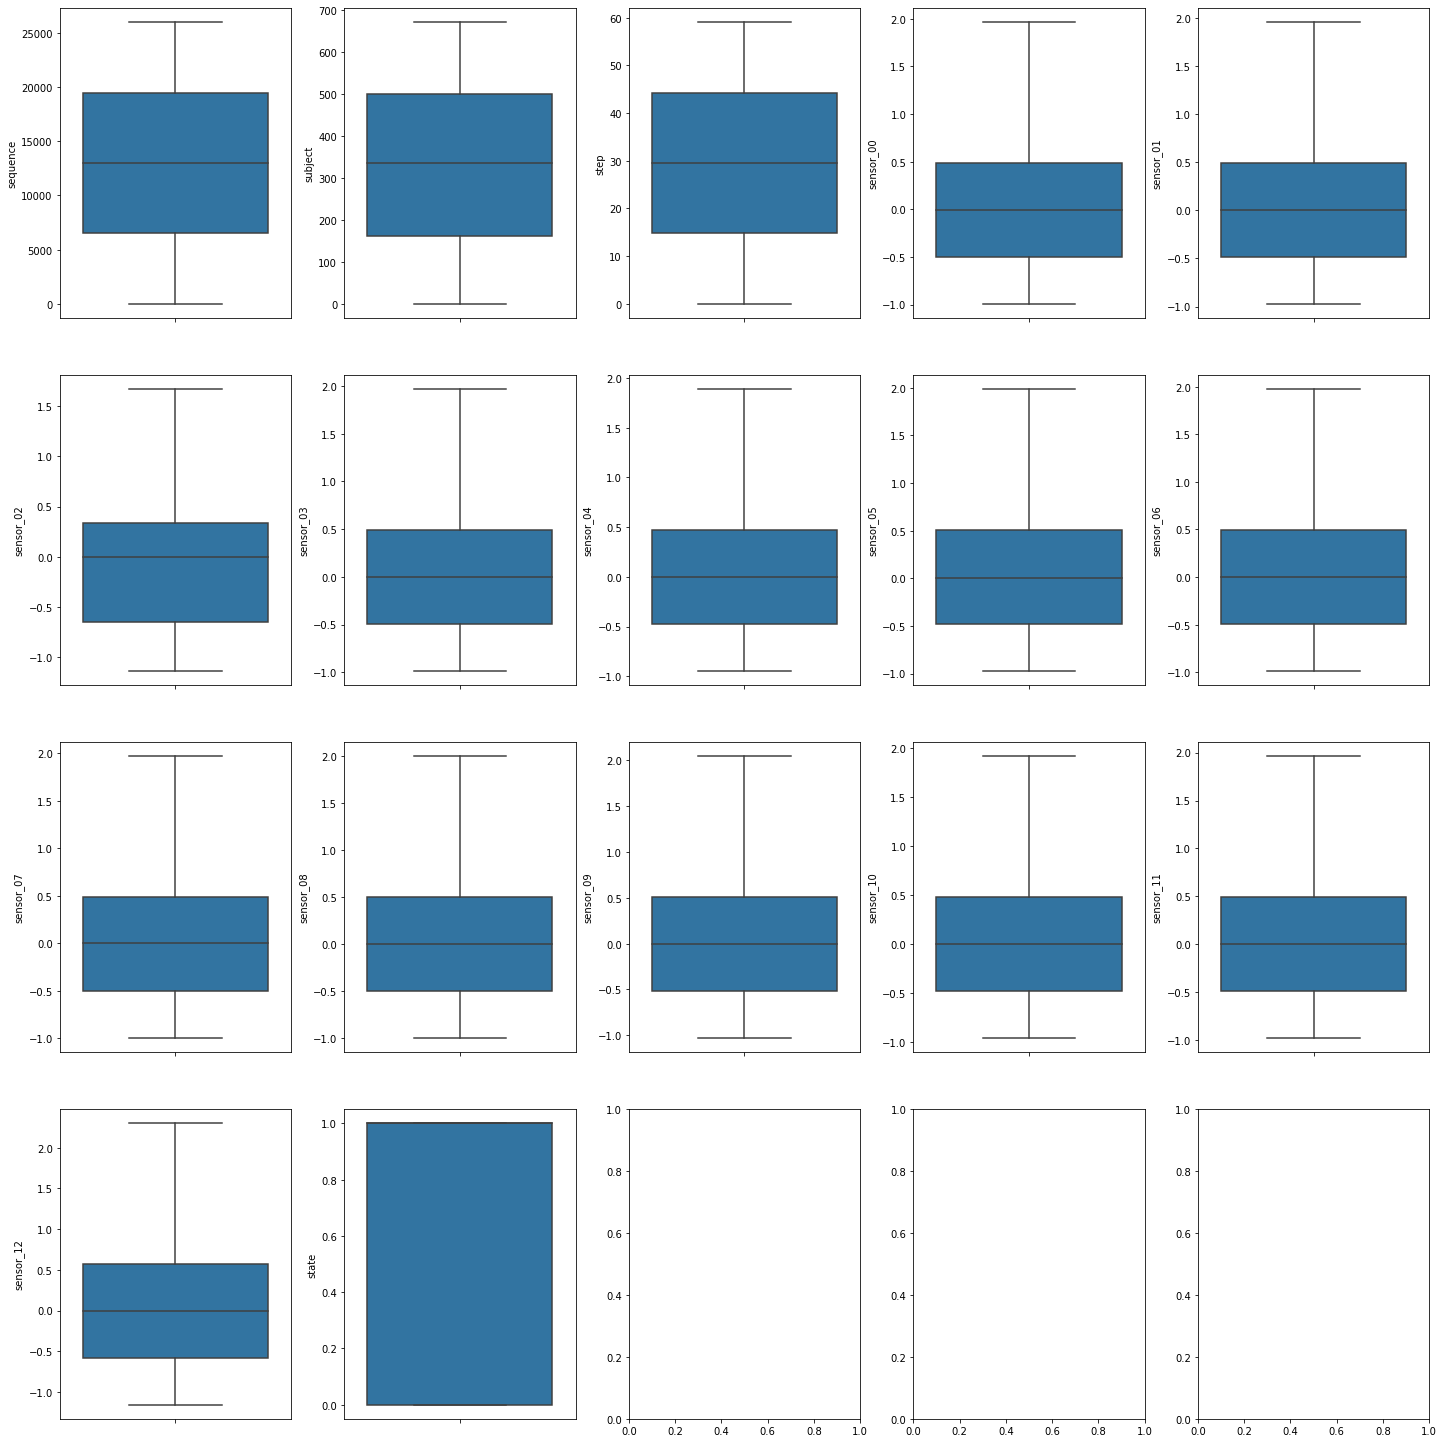

In [43]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 20))
index = 0
ax = ax.flatten()

for col in train.columns:
    sns.boxplot(y=col, data=train, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

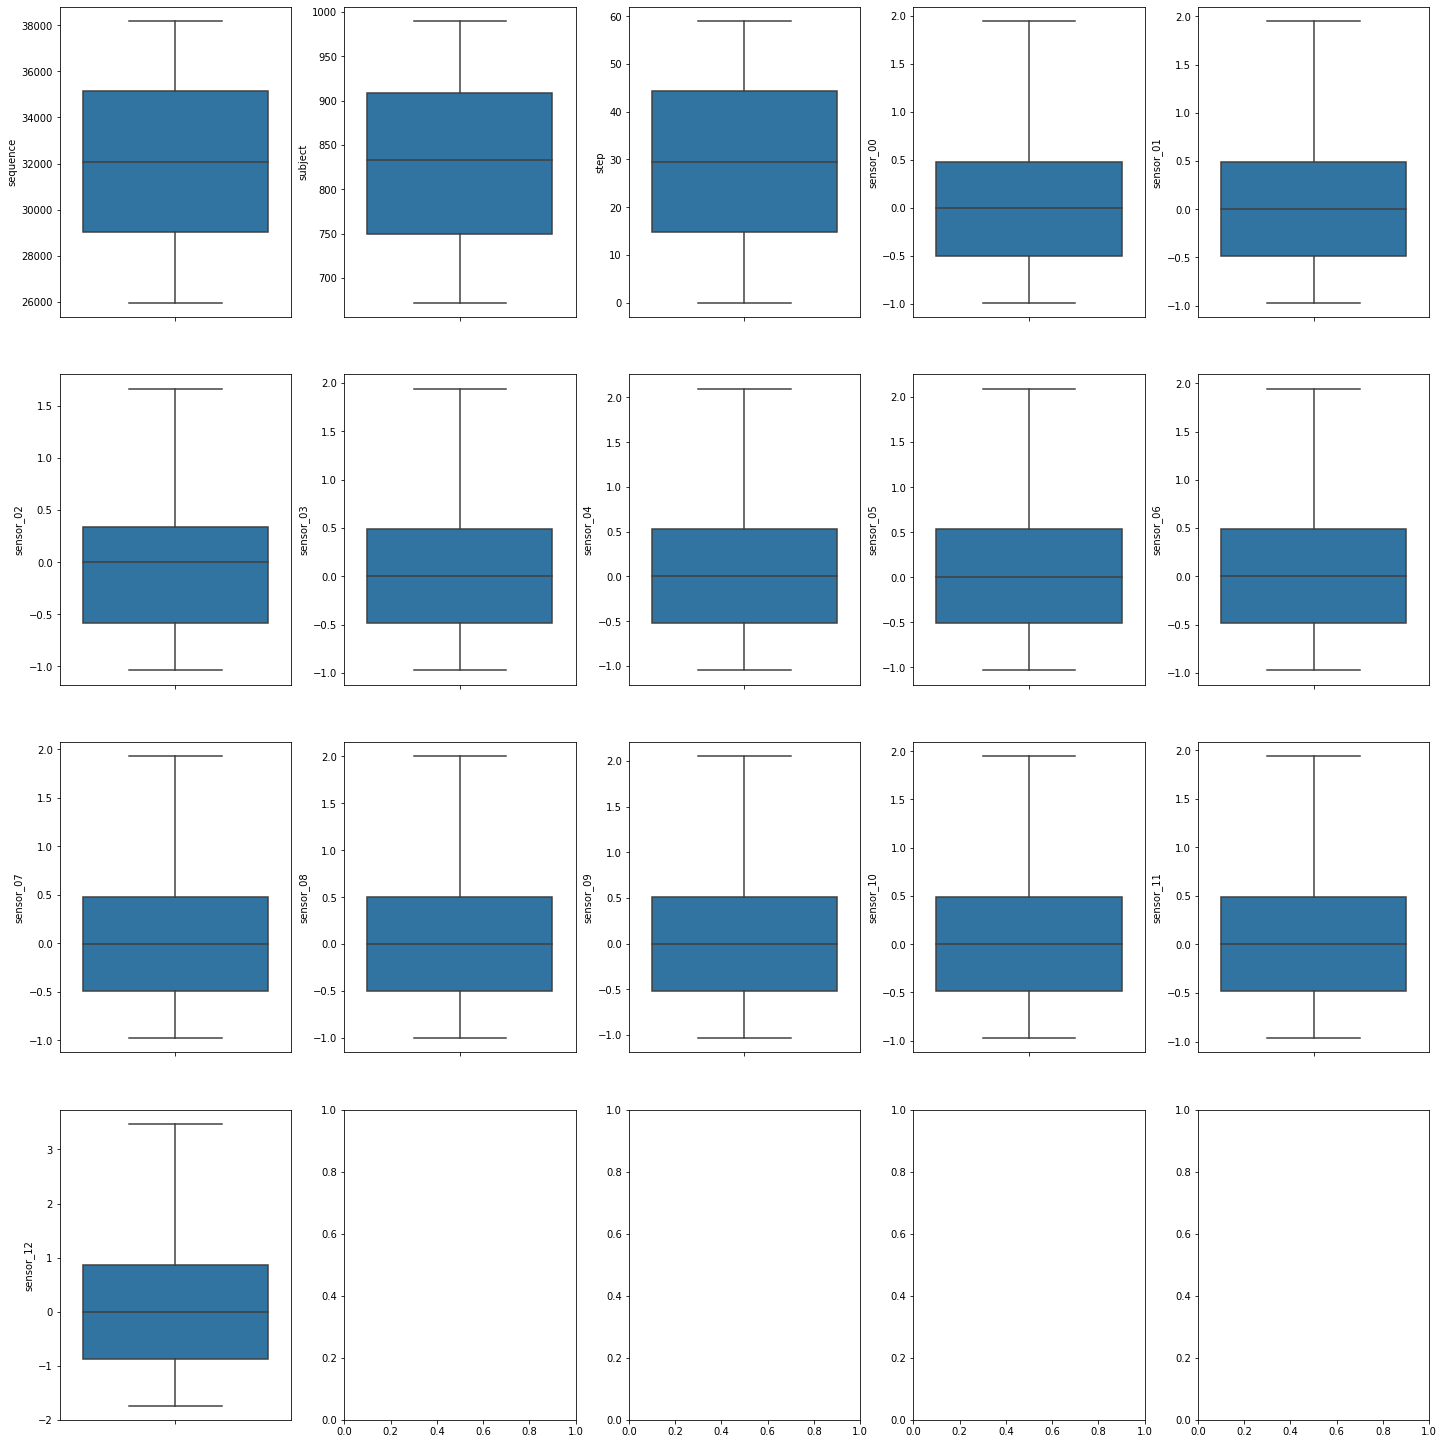

In [46]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 20))
index = 0
ax = ax.flatten()

for col in test_data.columns:
    sns.boxplot(y=col, data=test_data, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [47]:
train.shape

(1558080, 17)

In [48]:
test_data.shape

(733080, 16)

In [49]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-0.944567,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.957210,0.531893,2.296675,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-1.156010,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


In [50]:
train["state"].unique()

array([0, 1], dtype=int64)

In [51]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [52]:
x_train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
588564,9809,521,24,1.204791,0.542017,-0.666153,-0.861062,-0.944567,1.982049,1.680328,-0.868702,-0.8,0.932081,-0.274111,-0.972222,0.265558
503440,8390,248,40,-0.144513,-0.143908,-0.999486,-0.307080,0.713112,-0.757666,-0.153916,-0.149618,0.5,0.066474,0.777423,-0.304527,0.606564
1039246,17320,354,46,0.020866,-0.643908,-1.136153,0.176106,-0.944567,-0.191473,-0.517304,0.119847,-1.0,1.057081,-0.957210,-0.082305,-0.155158
1155073,19251,349,13,-0.581144,0.716387,0.038392,-0.323894,-0.012483,0.174271,-0.326958,-0.583206,-1.0,-0.536850,-0.123431,0.297325,-0.062660
1025713,17095,159,13,0.239567,0.174370,0.000000,-0.393805,1.884880,-0.970830,0.112933,0.097710,-0.1,-0.049133,1.021874,-0.283951,0.287298


In [53]:
y_train.head()

588564     0
503440     0
1039246    0
1155073    0
1025713    1
Name: state, dtype: int64

In [54]:
x_train.shape

(1246464, 16)

# Model Building

**Logistic Regression**

In [58]:
logr = LogisticRegression()
model = logr.fit(x_train,y_train)
pred = model.predict(x_test)
accuracy_score(y_test, pred)*100

54.04504261655371

In [59]:
score = []
for i in range(100):
    x = train.iloc[:,:-1]
    y = train.iloc[:,-1]

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=i)
    
    logr = LogisticRegression()
    logr.fit(x_train,y_train)
    pred = logr.predict(x_test)
    score.append(accuracy_score(y_test,pred)*100)
print("i= ",np.argmax(score))
print(score[np.argmax(score)])

i=  14

54.3348223454508


In [60]:
logr = LogisticRegression()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=np.argmax(score))

model1 = logr.fit(x_train,y_train)
pred = model1.predict(x_test)
accuracy_score(y_test, pred)*100

54.3348223454508

In [61]:
# Training Data Accuracy

pred = model1.predict(x_train)
accuracy_score(y_train, pred)*100      #Underfitting

54.09863421647155

In [62]:
#CROSS VALIDATION TO CHECK WHETHER THE MODEL IS GENERALIZED OR NOT

mod1 = cross_val_score(LogisticRegression(), x_train, y_train, cv=10)
print(mod1)
print(np.round(np.mean(mod1),2)*100)

[0.50925413 0.53966802 0.54192239 0.539307   0.54253646 0.53907065

 0.54201499 0.53854115 0.54124481 0.54261669]

54.0


**Decision Tree Classifier**

In [64]:
dtc = DecisionTreeClassifier(random_state=4)
dtc.fit(x_train,y_train)
pred = dtc.predict(x_test)
accuracy_score(y_test, pred)*100

87.78624974327377

In [66]:
score = []
for i in range(5):
    x = train.iloc[:,:-1]
    y = train.iloc[:,-1]

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=i)
    
    dtc = DecisionTreeClassifier(random_state=4)
    dtc.fit(x_train,y_train)
    pred = dtc.predict(x_test)
    score.append(accuracy_score(y_test,pred)*100)
print("i= ",np.argmax(score))
print(score[np.argmax(score)])

i=  1

89.64623125898542


In [67]:
dtc = DecisionTreeClassifier(random_state=4)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=np.argmax(score))

model2 = dtc.fit(x_train,y_train)
pred = model2.predict(x_test)
accuracy_score(y_test, pred)*100

89.64623125898542

In [68]:
# Training Data Accuracy

pred = model2.predict(x_train)
accuracy_score(y_train, pred)*100     #Generalized

100.0

In [70]:
#CROSS VALIDATION TO CHECK WHETHER THE MODEL IS GENERALIZED OR NOT

mod2 = cross_val_score(DecisionTreeClassifier(random_state=4), x_train, y_train, cv=5)
print(mod2)
print(np.round(np.mean(mod2),2)*100)

[0.8699442  0.86563602 0.87464951 0.87538358 0.86064134]

87.0


**Random Forest Classifier**

In [71]:
rfc = RandomForestClassifier(random_state=4)
rfc.fit(x_train,y_train)
pred = rfc.predict(x_test)
accuracy_score(y_test, pred)*100

71.88558995686999

In [73]:
rfc = RandomForestClassifier(random_state=4, n_jobs=-1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=np.argmax(score))

model3 = rfc.fit(x_train,y_train)
pred = model3.predict(x_test)
accuracy_score(y_test, pred)*100

71.463275313206

In [74]:
# Training Data Accuracy

pred = model3.predict(x_train)
accuracy_score(y_train, pred)*100     #Overfitting

100.0

In [75]:
#CROSS VALIDATION TO CHECK WHETHER THE MODEL IS GENERALIZED OR NOT

mod3 = cross_val_score(RandomForestClassifier(random_state=4, n_jobs=-1), x_train, y_train, cv=4)
print(mod3)
print(np.round(np.mean(mod3),2)*100)

[0.70356143 0.70310575 0.70586876 0.70460438]

70.0


In [80]:
test_data

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,1.948223,1.953782,1.000000,-0.973451,-1.048887,-1.035527,1.947177,-0.977481,2.0,-1.033237,-0.973895,1.939815,0.419011
1,25968,684,1,-0.986862,-0.970588,1.000000,0.983186,-0.569053,1.845924,-0.976321,1.727481,-1.0,0.395231,-0.882233,-0.964506,-0.008525
2,25968,684,2,1.136012,-0.970588,1.000000,1.016814,0.964157,2.094615,0.312386,1.154198,-1.0,1.114162,1.525273,-0.964506,0.139812
3,25968,684,3,0.806028,1.953782,1.000000,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-1.0,-0.588873,0.608761,-0.964506,-0.462916
4,25968,684,4,1.288253,1.953782,1.000000,-0.493805,-1.036124,-1.035527,1.947177,-0.730534,0.0,0.899566,-0.973895,-0.472222,-0.121483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.211747,1.953782,-1.038653,0.695575,-0.161327,-1.035527,0.421676,0.869466,0.0,-1.033237,0.388101,1.939815,-1.741049
733076,38185,773,56,-0.826121,-0.970588,-1.038653,0.381416,0.144745,1.060583,-0.765938,0.288550,0.2,-1.033237,-0.032158,-0.964506,3.475064
733077,38185,773,57,0.755023,1.469538,-1.038653,-0.973451,-0.414802,0.007479,0.907104,-0.977481,0.4,2.053468,0.150273,0.641975,-1.741049
733078,38185,773,58,-0.187017,0.714286,-1.038653,0.077876,1.323245,0.159312,-0.397996,0.306870,0.1,-1.013728,-0.608616,0.317901,3.475064


In [76]:
test_pred = model2.predict(test_data)
test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [77]:
submission = pd.DataFrame({"sequence": test_data["policy"],"state": test_pred})

In [78]:
submission.head()

,sequence,state
0,25968,0
1,25968,0
2,25968,0
3,25968,0
4,25968,0


In [79]:
submission.to_csv('tabular_playground_submission.csv', index=False)